In [50]:
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

## Goal: Generate survival curves for patient level data for genes

Steps

survival analysis as specified in this project plan https://docs.google.com/document/d/1m4oHf4mL8xrwRjJbfZEe02NuO8qJH8iIC7nJ9f8qKpY/edit

## Outputs
* survival plots for each gene for 4 different groups (90/90), (90/10), (75/75). (75/25)
* dataframe/csv of log rank p values for all genes and all groups

In [61]:
gene_file = 'neurotransmitters.csv'
survival_file = 'survival.csv'
data_dir = 'data'

In [62]:
df_gene = pd.read_csv(os.path.join(data_dir,gene_file),index_col = False)
df_survival = pd.read_csv(os.path.join(data_dir,survival_file))
df_gene.head()

,Unnamed: 0,tcga-2j-aab1-0,tcga-2j-aab4-0,tcga-2j-aab8-0,tcga-2j-aabe-0,tcga-2j-aabh-0,tcga-2j-aabk-0,tcga-2j-aabo-0,tcga-2j-aabp-0,tcga-2j-aabt-0,...,PCSI_0048-2,PCSI_0460-2,PCSI_0301-2,PCSI_0074-2,PCSI_0230-2,PCSI_0593-2,PCSI_0642-2,PCSI_0173-2,PCSI_0162-2,PCSI_0638-2
0,ADRA1A,0.043148,0.050034,0.094039,0.061250,0.051422,0.000000,0.122911,0.096120,0.166757,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.133030,0.0000,0.175142,0.000000
1,TH,0.071683,0.189696,0.000000,1.261224,0.057598,0.332888,1.711616,0.027776,0.167328,...,0.0,0.238072,0.602309,0.000000,0.415598,0.128172,0.308268,0.0000,0.000000,0.000000
2,ADRA1B,0.078007,0.361845,0.435173,0.299025,0.309316,0.212326,0.051056,0.891787,0.214118,...,0.0,0.218628,0.805710,0.137258,0.283317,0.609050,0.413612,0.0000,0.445487,1.224387
3,DDC,1.552448,1.877340,2.757339,0.664721,2.397118,2.763167,2.173699,0.000000,2.750552,...,0.0,0.000000,1.015937,1.979122,1.328823,2.908710,3.581678,0.5016,3.788941,3.393806
4,ADRA1D,0.090623,0.463925,0.087224,0.144290,0.159559,0.180366,0.063566,0.156622,0.246254,...,0.0,0.000000,0.000000,0.030806,0.116771,0.000000,0.089103,0.0000,0.470698,0.000000


In [63]:
df_gene = df_gene.rename({'Unnamed: 0':'Gene'},axis = 1)
df_gene = df_gene.set_index(keys = ['Gene'])

In [64]:
df_gene_transposed = df_gene.T
df_gene_transposed.reset_index(inplace = True)
df_gene_transposed.rename({'index':'ID'}, inplace=True, axis = 1)

## Visualize distribution of genes

In [65]:
df_gene_transposed.head()

Gene,ID,ADRA1A,TH,ADRA1B,DDC,ADRA1D,DBH,ADRA2A,COMT,ADRA2B,...,DRD1,PAH,DRD2,DRD3,DRD4,DRD5,NPY1R,NPY,NPY2R,NPY5R
0,tcga-2j-aab1-0,0.043148,0.071683,0.078007,1.552448,0.090623,0.232059,4.413756,4.669536,0.876059,...,0.071354,1.785825,0.185648,0.0,0.906642,0.044983,0.270380,0.365206,0.000000,0.039661
1,tcga-2j-aab4-0,0.050034,0.189696,0.361845,1.877340,0.463925,0.226505,3.689998,4.454937,1.207446,...,0.456172,2.808329,0.440604,0.0,0.717959,0.028027,1.611107,2.471634,0.000000,0.155800
2,tcga-2j-aab8-0,0.094039,0.000000,0.435173,2.757339,0.087224,0.028863,3.356448,4.374988,0.646534,...,0.338657,0.000000,0.170896,0.0,0.924472,0.000000,0.361589,0.000000,0.370835,0.086658
3,tcga-2j-aabe-0,0.061250,1.261224,0.299025,0.664721,0.144290,0.155538,3.501180,4.732883,0.457381,...,1.703355,1.267026,0.154365,0.0,1.707515,0.042986,1.551727,0.873318,0.014961,0.000000
4,tcga-2j-aabh-0,0.051422,0.057598,0.309316,2.397118,0.159559,0.080069,3.495283,3.662019,0.260071,...,0.403738,1.494904,0.258002,0.0,0.644890,0.000000,1.060144,1.790240,0.000000,0.000000


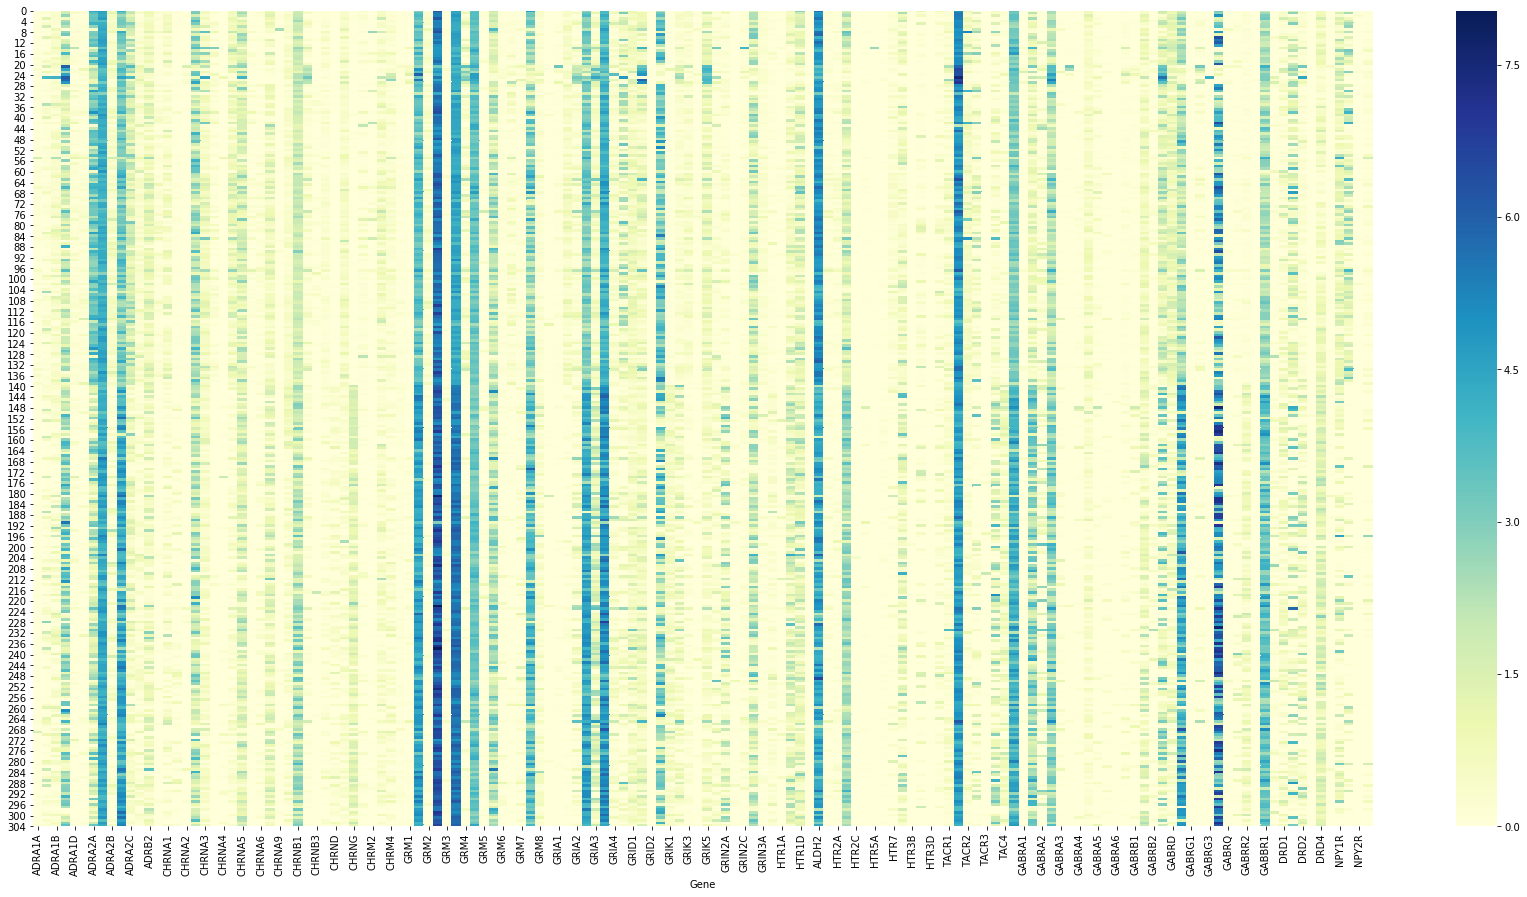

In [66]:
plt.figure(figsize = (30,15))
sns.heatmap(df_gene_transposed.drop(['ID'],axis = 1),cmap="YlGnBu")

In [67]:
df_gene_transposed.shape

(308, 145)

In [68]:
gene_column_list = [col for col in list(df_gene_transposed.columns) if 'ID' not in col]

In [69]:
df_survival.shape

(309, 5)

In [70]:
df_survival.head()

,pid,OS,OS_status,PFS,PFS_status
0,tcga-2j-aab1-0,2.169839,1.0,2.169839,0.0
1,tcga-2j-aab4-0,23.966861,0.0,23.966861,0.0
2,tcga-2j-aab8-0,2.630108,0.0,2.630108,0.0
3,tcga-2j-aabe-0,22.224414,0.0,22.224414,0.0
4,tcga-2j-aabk-0,15.912154,0.0,15.912154,0.0


## merge datasets

In [95]:
df_joined = pd.merge(df_gene_transposed, df_survival, left_on = ['ID'], right_on = ['pid'], how = 'inner')

In [96]:
df_joined.shape

(307, 150)

In [98]:
df_joined = df_joined[df_joined['ID'].str.contains('tcga')]
df_joined.shape

(139, 150)

## visualize missing data

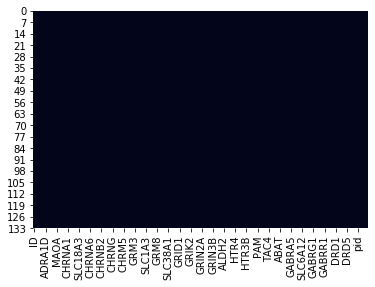

In [99]:
sns.heatmap(df_joined.isnull(), cbar = False)

In [100]:
percentile_list = [
    (50,50),
    (25, 75),
    (10, 90),
    (75, 75),
    (90, 90)
]

gene_list = []
high_list = []
low_list = []
p_list = []
count_high_list = []
count_low_list = []
value_high_list = []
value_low_list = []
longer_survival_list = []

for idx, gene in enumerate(gene_column_list):
    df_gene = df_joined[[gene,'OS', 'OS_status']]

    for percentile_low, percentile_high in percentile_list:
        
        value_high = np.percentile(df_gene[gene], percentile_high)
        value_low = np.percentile(df_gene[gene], percentile_low)
        
        df_high = df_gene[df_gene[gene] > value_high]
        df_low = df_gene[df_gene[gene] <= value_low]
        
        mean_high = df_high['OS'].mean()
        mean_low = df_low['OS'].mean()
        
        if mean_high > mean_low:
            longer_survival = 'above'
        else:
            longer_survival = 'below'

        duration_high = df_high['OS']
        duration_low = df_low['OS']
        
        observed_high = df_high['OS_status'].astype(int)
        observed_low = df_low['OS_status'].astype(int)
        
        res = logrank_test(duration_high,duration_low, observed_high, observed_low)
        p_value = res.p_value
        
        gene_list.append(gene)
        high_list.append(percentile_high)
        low_list.append(percentile_low)
        p_list.append(p_value)
        count_high_list.append(df_high.shape[0])
        count_low_list.append(df_low.shape[0])
        value_high_list.append(value_high)
        value_low_list.append(value_low)
        longer_survival_list.append(longer_survival)
        
        if p_value < .1:
            plt.figure()
            ax = plt.subplot(111)
            kmf = KaplanMeierFitter()
            kmf.fit(duration_high, observed_high, label="Above {:.0f} percentile".format(percentile_high))
            ax = kmf.plot(ax=ax)

            kmf.fit(duration_low, observed_low,label="Below {:.0f} percentile".format(percentile_low))
            ax = kmf.plot(ax=ax)

            ax.set_title("Kaplan Meier Curve - {}".format(gene));
            ax.set_ylabel('survival')
            plt.savefig('plots_tcga/{}_{}_high_{}_low.png'.format(gene,percentile_high,percentile_low))
            plt.close()
        
        print('done with {}/{}'.format(idx+1, len(gene_column_list)))

done with 1/142
done with 1/142
done with 1/142
done with 1/142
done with 1/142
done with 2/142
done with 2/142
done with 2/142
done with 2/142
done with 2/142
done with 3/142
done with 3/142
done with 3/142
done with 3/142
done with 3/142
done with 4/142
done with 4/142
done with 4/142
done with 4/142
done with 4/142
done with 5/142
done with 5/142
done with 5/142
done with 5/142
done with 5/142
done with 6/142
done with 6/142
done with 6/142
done with 6/142
done with 6/142
done with 7/142
done with 7/142
done with 7/142
done with 7/142
done with 7/142
done with 8/142
done with 8/142
done with 8/142
done with 8/142
done with 8/142
done with 9/142
done with 9/142
done with 9/142
done with 9/142
done with 9/142
done with 10/142
done with 10/142
done with 10/142
done with 10/142
done with 10/142
done with 11/142
done with 11/142
done with 11/142
done with 11/142
done with 11/142
done with 12/142
done with 12/142
done with 12/142
done with 12/142
done with 12/142
done with 13/142
done wit

In [93]:
output_df = pd.DataFrame(
{'gene': gene_list,
'above_percentile': high_list,
'below_percentile':low_list,
'p_value': np.round(p_list,4),
'count_above': count_high_list,
'count_below': count_low_list,
'above_percentile_value': np.round(value_high_list,4),
'below_percentile_value': np.round(value_low_list,4),
'longer_survival':longer_survival_list
}
)

In [94]:
output_df.to_csv('data/logrank_results_tcga.csv',index=False)

In [35]:
grouped_df = output_df.groupby(['above_percentile','below_percentile'],group_keys = False, as_index = False).mean()

In [48]:
grouped_df = grouped_df.rename({'p_value':'mean_p_value'},axis =1)

In [49]:
grouped_df[['above_percentile', 'below_percentile', 'mean_p_value']]

,above_percentile,below_percentile,mean_p_value
0,50,50,0.379527
1,75,25,0.375336
2,75,75,0.389396
3,90,10,0.360616
4,90,90,0.393466


In [45]:
df_below_p.reset_index()

,above_percentile,below_percentile,count below p=.05
0,50,50,19
1,75,25,23
2,75,75,23
3,90,10,20
4,90,90,24


In [37]:
def count_below_p(df, p_value):
    df_below = df[df['p_value'] < p_value]
    return df_below.shape[0]
    

In [39]:
df_below_p = output_df.groupby(['above_percentile','below_percentile'],group_keys = False, as_index = False).apply(count_below_p,.05)

In [43]:
df_below_p = pd.DataFrame(df_below_p)
df_below_p.columns = ['count below p=.05']